%md 
# 1.0 Introduction to PyG
## 1.1 Understanding the API

In [4]:
import torch
from torch_geometric.data import Data

In [5]:
edge_index=torch.tensor([[0,1,1,2],[1,0,2,1]],dtype=torch.long)
x=torch.tensor([[-1],[0],[1]], dtype=torch.float)
data=Data(x=x,edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

%md
## 1.2 Visualize our newly created graph

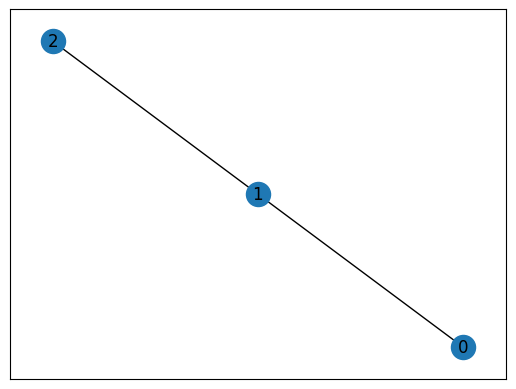

In [14]:
import networkx as nx
from torch_geometric import utils
graph = utils.to_networkx(data, to_undirected=True)
nx.draw_networkx(graph)

In [15]:
# Validate our graph is built well
data.validate(raise_on_error=True)

True

%md
## 1.3 Play with Enzyme graph. Each grpah has a graph-level attribute

In [16]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...


600
6
3


Done!


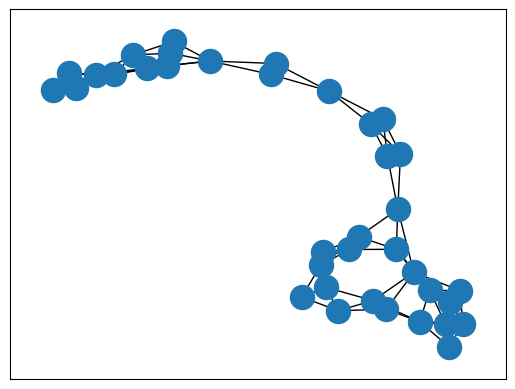

In [19]:
data_enz = dataset[0]
graph_enz = utils.to_networkx(data=data_enz,to_undirected=True)
nx.draw_networkx(graph_enz, with_labels=False)


In [20]:
data_enz.y

tensor([5])

%md
## 1.4 Play with Cora dataset

In [21]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

1
7
1433


Processing...
Done!


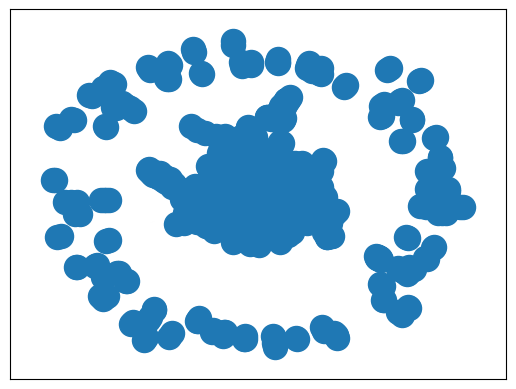

In [23]:
data_citation = dataset[0]
graph_citation = utils.to_networkx(data_citation)
nx.draw_networkx(graph_citation, with_labels=False)

%md
## 1.5 Implement the Cora graph neural network

In [24]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset.num_node_features

In [25]:
from torch.nn import functional as F, Module
from torch_geometric.nn import GCNConv as GCNConv

# Subclass the GCN model
class GCN(Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Stack the network
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [27]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7950
